<a href="https://colab.research.google.com/github/PetrBonyuk/data_analysis/blob/main/factoranalis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install factor-analyzer


Цель: решить задачу факторного анализа с использованием библиотеки FactorAnalyzer в Python, описать ход решения и вычислительного процесса, оценить полученное решение, сравнить с аналогичными вычислениями, реализованными с помощью SPSS.  

---

В основных комментариях показан анализ и основные рассуждения касательно решения задачи факторного анализа, а так же сравнение полученных результатов с решением SPSS. Комментарии, касательно особенностей реализации решения задачи факторного анализа с использованием библиотеки FactorAnalyzer в Python, подробно расписаны непосредственно в ячейках с кодом, посмотреть которые можно, нажав на кнопку "Показать код".

# Постановка задачи

В рамках маркетингового исследования 18 экспертов проводят дегустацию 6 вариантов безалкогольных напитков. Каждый эксперт на каждый испробованный напиток заполняет анкету. Анкета содержит 10 утверждений относительно напитка (см. табл.), и эксперт должен выразить свое согласие или несогласие с каждым из них по 7-балльной шкале. В случае полного несогласия с утверждением эксперт выставляет 1 балл, в случае абсолютного согласия – 7 баллов. Кроме того, в анкете проставляется кодовый номер эксперта, заполнившего анкету, и кодовый номер напитка, который он оценивает.

## Таблица

| № | Утверждение | Переменная |
|---|-------------|------------|
| 1 | У напитка освежающий вкус | x_1 |
| 2 | Я предпочитаю этот напиток, потому что в нем меньше калорий, чем в других | x_2 |
| 3 | Напиток мгновенно утоляет жажду | x_3 |
| 4 | Мне нравится сладкий вкус этого напитка | x_4 |
| 5 | Я предпочитаю этот напиток после занятий спортом и физических нагрузок: он заряжает энергией | x_5 |
| 6 | Я предпочитаю этот напиток, потому что он выпускается в экологически чистой упаковке | x_6 |
| 7 | Напиток содержит витамины и минералы, помогающие справиться с жаждой | x_7 |
| 8 | У напитка есть свой уникальный вкус | x_8 |
| 9 | Напиток богат витаминами и минералами, полезными для здоровья | x_9 |
| 10 | Я предпочитаю этот напиток, если действительно хочется пить | x_10 |

Результаты анкетирования содержатся в файле `маркетинг.sav` и организованы следующим образом. Каждая анкета рассматривается как объект (наблюдение) и характеризуется значениями 13 признаков (переменных):

- `анкета` – порядковый номер анкеты,
- `эксперт` – кодовый номер эксперта, заполнившего анкету,
- `марка` – кодовый номер напитка, о котором идет речь в анкете,
- `x_1-x_10` – баллы, выражающие отношение эксперта к напитку соответственно утверждениям из табл. 3.1.

Далее переменные `x_1-x_10` будем называть ответами.

Файл `Book.xlsx` организован таким образом, что каждая анкета представлена отдельной строкой файла, а каждая из 13 переменных – отдельным столбцом. Из-за того, что не всем экспертам удалось дегустировать все шесть напитков, в ходе исследования были собраны не 18×6=108 анкет, а всего лишь 95. Как следствие, файл содержит 95 строк.

Рассмотрим анкеты как объекты, ответы – как признаки и для изучения корреляции ответов используем факторный анализ.

In [327]:
# @title Подключение библиотек. Загрузка данных
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from factor_analyzer import FactorAnalyzer # Библиотека для использования факторного анализа в Python
from google.colab import files
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, message=".*'force_all_finite' was renamed to 'ensure_all_finite'.*")
uploaded = files.upload()

Saving Book.xlsx to Book (6).xlsx


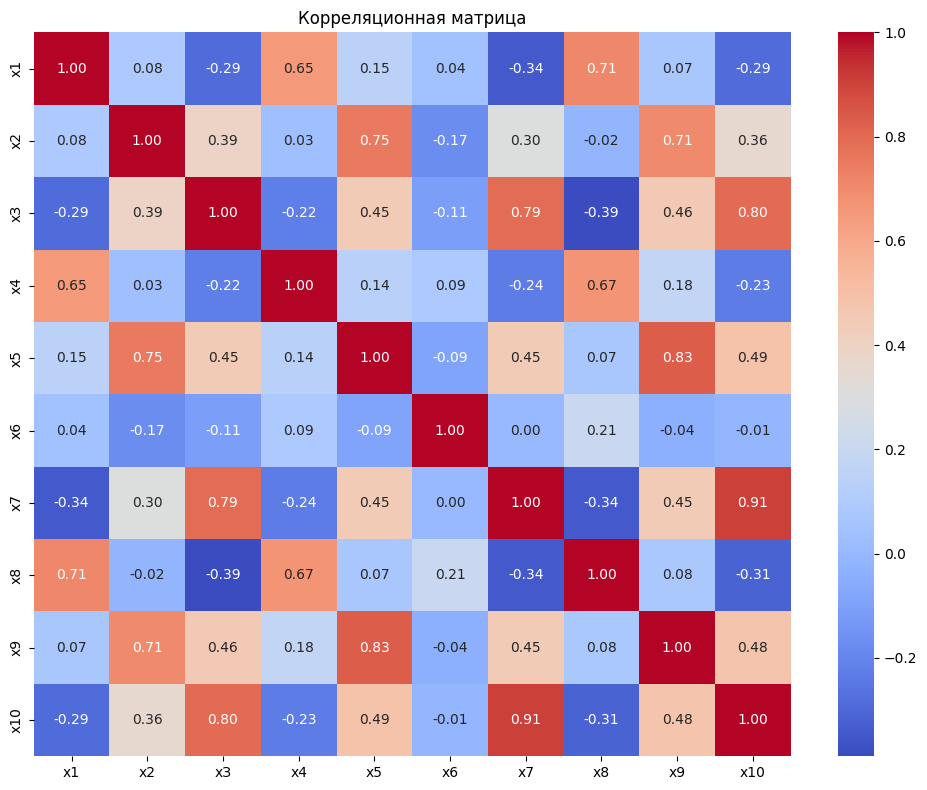

In [310]:
#@title Чтение файла. Удаление категориальных признаков. Построение матрицы корреляции.
data_raw  = pd.read_excel("Book.xlsx")
data = data_raw.drop(columns = ['эксперт', 'марка'])
correlation_matrix = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Корреляционная матрица')
plt.tight_layout()

### Почему нужно анализировать матрицу корреляции перед факторным анализом?

Факторный анализ используется для выявления скрытых (латентных) факторов, которые объясняют наблюдаемые корреляции между переменными. Анализ матрицы корреляции перед проведением факторного анализа необходим по следующим причинам:

1. **Проверка применимости факторного анализа**: Если переменные не коррелируют между собой, факторный анализ будет бесполезен. Анализ матрицы корреляции позволяет убедиться, что между переменными существуют значимые связи.
2. **Выявление сильных корреляций**: Сильные корреляции между переменными указывают на возможное наличие общих факторов, которые можно выделить.
3. **Исключение некоррелированных переменных**: Если переменная не коррелирует с остальными, она не будет вносить вклад в факторную структуру и может быть исключена из анализа (как в случае с \(x_6\)).

---

### Анализ матрицы корреляции

В таблице корреляции можно выделить следующие **сильные корреляции** (обычно считаются сильными при \(|r| > 0.5\)):

- \(x_1\) (освежающий вкус) сильно коррелирует с \(x_4\) (сладкий вкус, \(r = 0.651\)) и \(x_8\) (уникальный вкус, \(r = 0.710\)).
- \(x_2\) (меньше калорий) сильно коррелирует с \(x_5\) (заряжает энергией, \(r = 0.754\)) и \(x_9\) (богат витаминами, \(r = 0.706\)).
- \(x_3\) (утоляет жажду) сильно коррелирует с \(x_7\) (содержит витамины, \(r = 0.790\)) и \(x_{10}\) (предпочтение при жажде, \(r = 0.798\)).
- \(x_4\) (сладкий вкус) сильно коррелирует с \(x_1\) (освежающий вкус, \(r = 0.651\)) и \(x_8\) (уникальный вкус, \(r = 0.672\)).
- \(x_5\) (заряжает энергией) сильно коррелирует с \(x_2\) (меньше калорий, \(r = 0.754\)) и \(x_9\) (богат витаминами, \(r = 0.834\)).
- \(x_7\) (содержит витамины) сильно коррелирует с \(x_3\) (утоляет жажду, \(r = 0.790\)) и \(x_{10}\) (предпочтение при жажде, \(r = 0.898\)).
- \(x_9\) (богат витаминами) сильно коррелирует с \(x_2\) (меньше калорий, \(r = 0.706\)) и \(x_5\) (заряжает энергией, \(r = 0.834\)).
- \(x_{10}\) (предпочтение при жажде) сильно коррелирует с \(x_3\) (утоляет жажду, \(r = 0.798\)) и \(x_7\) (содержит витамины, \(r = 0.898\)).

---

Переменная \(x_6\) (экологически чистая упаковка) не имеет значимых корреляций с другими переменными (все \(|r| < 0.2\)). Это указывает на то, что она **не связана** с остальными характеристиками напитка, такими как вкус, энергетические свойства или содержание витаминов. Поскольку факторный анализ направлен на выявление общих факторов, объясняющих корреляции между переменными, \(x_6\) не будет вносить вклад в факторную структуру и может быть исключена из анализа.

---

### Сравнение с матрицей корреляции, полученной с помощью SPSS

Матрица корреляции:

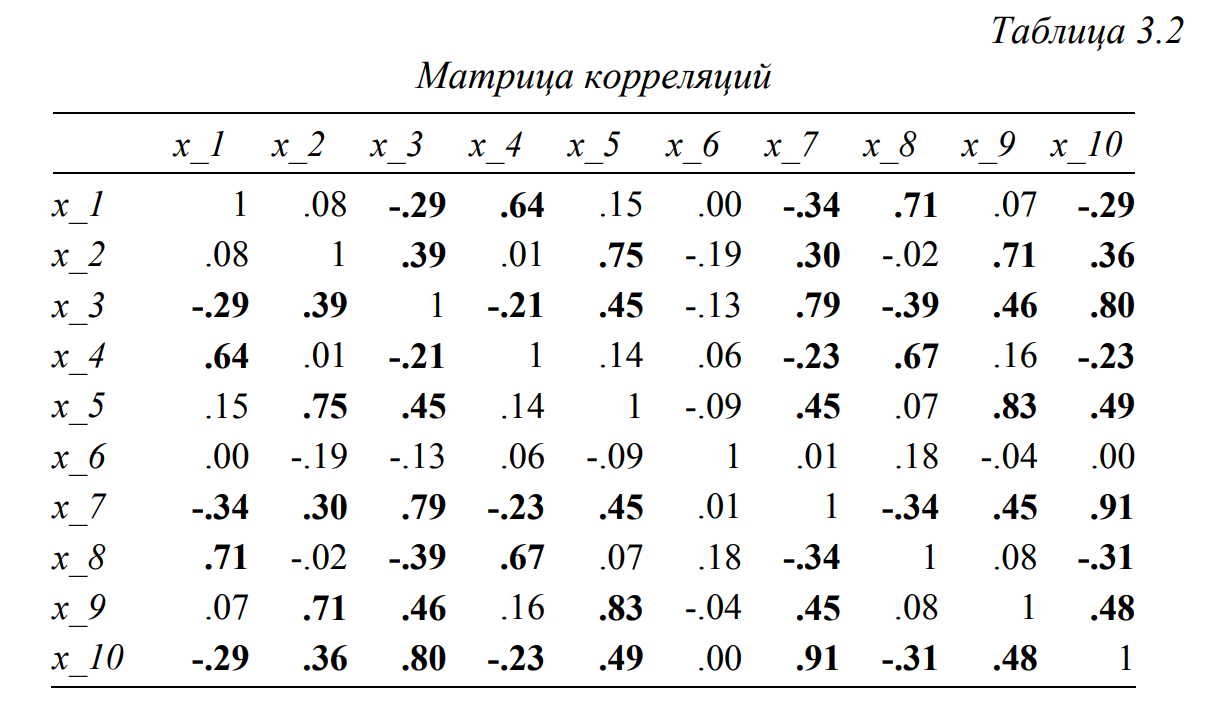

Как можно заметить, матрицы корреляции, полученные с помощью SPSS и Python  немного отличаются, это говорит о расхождении исходных данных. Как бы там ни было, расхождения в матрице корреляции не превышают 0.03, а значит на факторное решение это не сильно повлияет. Судя по матрице корреляции, расхождение находится где-то в столбце x_4, однако при дополнительной проверке, ошибки не нашлось, что может говорить об опечатке в методичке.

In [311]:
#@title Удаление признаков после анализа матрицы корреляции
data = data.drop(columns = ['x6'])
print("Исходные данные после удаления x_6")
data

Исходные данные после удаления x_6


,x1,x2,xЗ,x4,x5,x7,x8,x9,x10
0,4,3,5,1,3,5,3,3,4
1,5,2,4,1,2,4,5,2,4
2,4,5,6,4,2,6,4,5,5
3,4,5,5,5,5,6,4,5,6
4,7,6,6,6,7,5,6,6,5
...,...,...,...,...,...,...,...,...,...
90,6,6,6,5,5,6,5,5,5
91,7,5,5,7,4,5,6,4,5
92,4,4,4,2,3,4,4,4,4
93,4,5,5,5,5,5,5,5,5


In [312]:
# @title Факторный анализ. Объяснённая дисперсия факторов

# Импорт необходимых библиотек
from factor_analyzer import FactorAnalyzer  # Для проведения факторного анализа
import pandas as pd  # Для работы с таблицами данных

# Инициализация и обучение модели
# FactorAnalyzer — класс для проведения факторного анализа
# n_factors=2: количество факторов, которые мы хотим извлечь
# rotation='varimax': метод вращения факторов (Varimax — ортогональное вращение)
fa = FactorAnalyzer(n_factors=2, rotation='varimax')

# Обучение модели на данных
# data — DataFrame с исходными данными (каждый столбец — это переменная, каждая строка — наблюдение)
fa.fit(data)

# Получение собственных значений (eigenvalues)
# Собственные значения показывают, сколько дисперсии объясняет каждый фактор
# eigenvalues — массив собственных значений для каждого фактора
# _ — игнорируемый вывод (в данном случае это матрица нагрузок)
eigenvalues, _ = fa.get_eigenvalues()

# Создание таблицы для отображения результатов
# DataFrame — таблица, которая будет содержать информацию о факторах
factor_table = pd.DataFrame({
    'Фактор': range(1, len(eigenvalues) + 1),  # Номера факторов (1, 2, ...)
    'Дисперсия': eigenvalues,  # Собственные значения (дисперсия, объясняемая каждым фактором)
    '% Объяснённой дисперсии': (eigenvalues / eigenvalues.sum()) * 100,  # Процент объяснённой дисперсии
    'Накопленный %': (eigenvalues.cumsum() / eigenvalues.sum()) * 100  # Накопленный процент объяснённой дисперсии
})

# Округление значений для удобства чтения
# round(3) — округление всех значений в таблице до 3 знаков после запятой
factor_table = factor_table.round(3)

# Отображение таблицы с улучшенным форматированием
# display — функция для красивого отображения таблиц в Jupyter Notebook или Google Colab
# set_caption — добавление заголовка к таблице
# set_properties — настройка выравнивания текста в таблице
# format — форматирование числовых значений в таблице
display(factor_table.style
        .set_caption("Таблица показывает вклад каждого фактора в объяснение общей дисперсии данных.")
        .set_properties(**{'text-align': 'center'})
        .format({'Дисперсия': '{:.3f}', '% Объяснённой дисперсии': '{:.3f}', 'Накопленный %': '{:.3f}'}))

,Фактор,Дисперсия,% Объяснённой дисперсии,Накопленный %
0,1,4.033,44.816,44.816
1,2,2.662,29.580,74.396
2,3,0.908,10.085,84.480
3,4,0.389,4.318,88.798
4,5,0.341,3.787,92.585
5,6,0.236,2.617,95.202
6,7,0.201,2.236,97.438
7,8,0.141,1.567,99.005
8,9,0.090,0.995,100.000


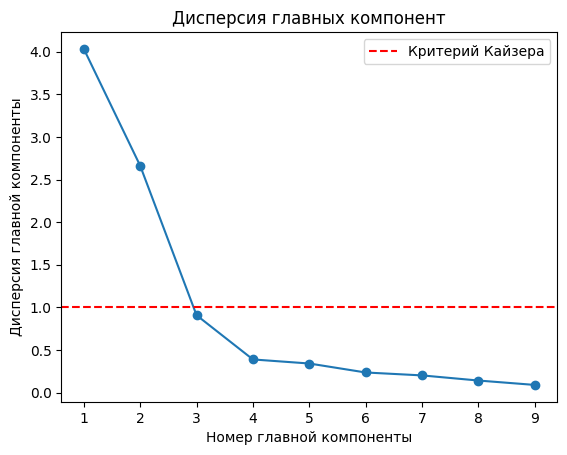

In [313]:
# @title График объясненной дисперсии  главных компонент
import matplotlib.pyplot as plt

plt.scatter(range(1, data.shape[1]+1), eigenvalues)
plt.plot(range(1, data.shape[1]+1), eigenvalues)
plt.title('Дисперсия главных компонент')
plt.xlabel('Номер главной компоненты')
plt.ylabel('Дисперсия главной компоненты')
plt.axhline(y=1, color='r', linestyle='--', label="Критерий Кайзера")
plt.legend()
plt.show()

# Анализ вкладов факторов в объяснение суммарной дисперсии

Факторный анализ выявляет скрытые факторы, объясняющие корреляции между переменными. Анализ объяснённой дисперсии помогает определить, сколько факторов значимо.

---

## Критерий Кайзера:
- Факторы с дисперсией > 1 считаются значимыми (объясняют больше дисперсии, чем одна переменная).
- На графике Scree Plot горизонтальная линия y=1 помогает выбрать количество факторов.

## Накопленная дисперсия:
- Показывает, какую долю общей дисперсии объясняют выделенные факторы.
- Помогает оценить, насколько хорошо факторы описывают данные.

## Scree Plot:
- Визуализация дисперсии факторов. "Локоть" указывает оптимальное количество факторов.

---

# Результаты анализа:

1. **Объяснённая дисперсия**:
   - **Фактор 1**: 44.82% (наиболее значимый).
   - **Фактор 2**: 29.58% (вместе с Фактором 1 — 74.17%).
   - **Фактор 3**: 10.08% (суммарно — 84.41%).
   - Остальные факторы (4–9) объясняют < 5% каждый.

2. **Критерий Кайзера**:
   - **Факторы 1 и 2**: Дисперсия > 1 (значимы).
   - **Фактор 3**: Дисперсия ≈ 0.92 (чуть меньше 1).

3. **Накопленная дисперсия**:
   - Первые два фактора объясняют 74.17%.
   - Добавление третьего фактора увеличивает до 84.41%.

---

# Метод главных компонент:
- Использовался для извлечения факторов.
- Позволяет выделить компоненты, объясняющие максимальную дисперсию.
- В отличие от классического факторного анализа, не предполагает скрытой структуры, а сокращает размерность данных.

---

## Итог:
- Первые три фактора объясняют 84.41% дисперсии.
- Факторы 1 и 2 наиболее значимы.
- Метод главных компонент эффективно сокращает размерность данных.

# Сравнение с решением, полученным с помощью SPSS.

Решение SPSS выдало следующие значения вкладов факторов в объяснение сумарной дисперсии.

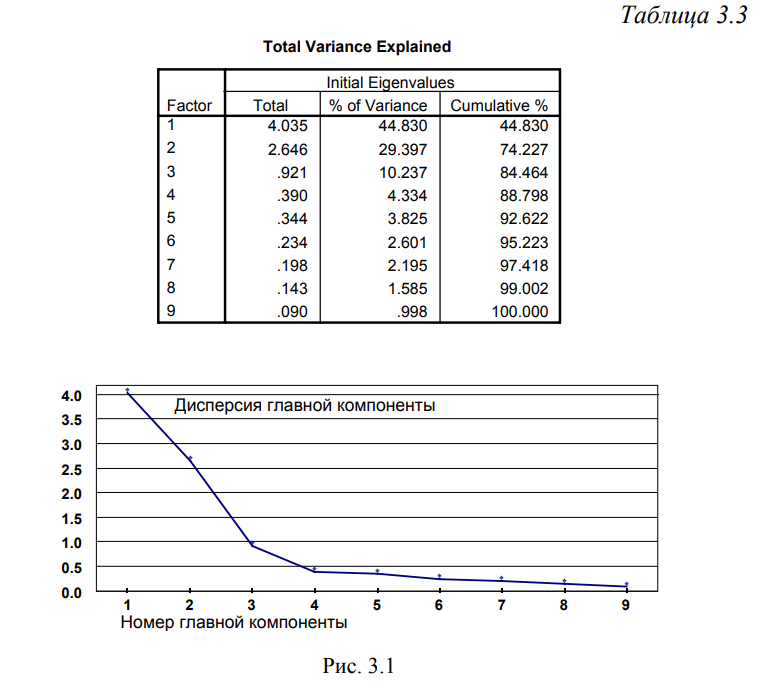

Значения таблицы, полученной с помощью SPSS незначительно отличаются по сравнению с таблицей, полученной с помощью Python. Это может указывать как небольшие ошибки при переносе исходных данных или на различие вычислительных алогритмов Python и SPSS. Так или иначе погрешность не превышает 0.005, и небольшие различия в значениях не влияют на общую интерпретацию результатов. Оба пакета показывают, что первые два фактора объясняют большую часть дисперсии.

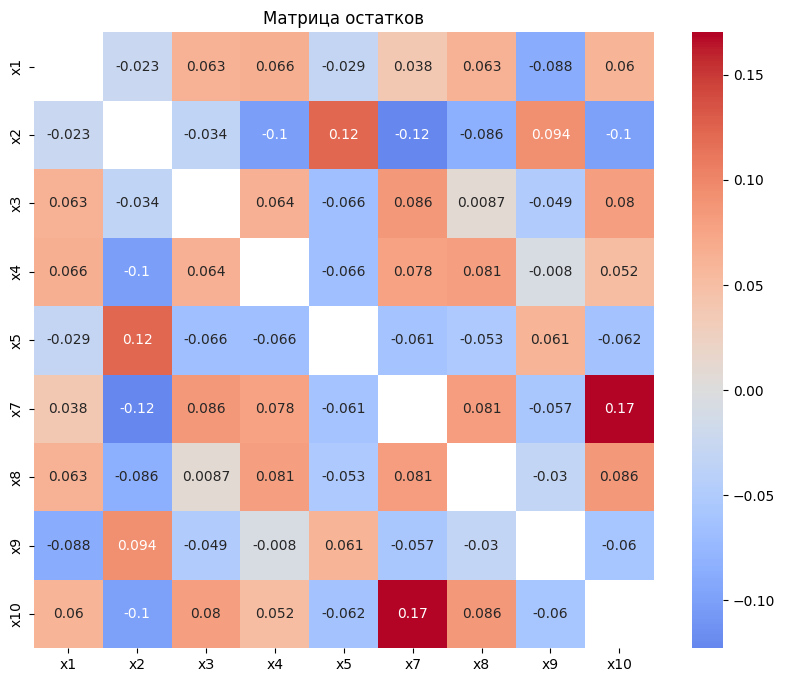

In [314]:
# @title Вычисление и визуализация матрицы остатков

# Получение факторных нагрузок
# loadings — матрица факторных нагрузок, показывающая связь между переменными и факторами
loadings = fa.loadings_

# Получение характерностей (uniquenesses)
# Характерности показывают долю дисперсии каждой переменной, которая не объясняется общими факторами
uniquenesses = fa.get_uniquenesses()

# Воспроизведённая матрица корреляций
# Вычисляется как произведение матрицы нагрузок на её транспонированную версию
# Это матрица корреляций, которую модель факторного анализа пытается воспроизвести
reproduced_corr = np.dot(loadings, loadings.T)

# Исходная матрица корреляций
# Вычисляется на основе исходных данных с помощью функции np.corrcoef
# rowvar=False указывает, что каждая строка в данных представляет наблюдение, а столбцы — переменные
original_corr = np.corrcoef(data, rowvar=False)

# Матрица остатков
# Разница между исходной и воспроизведённой матрицами корреляций
# Остатки показывают, насколько хорошо модель факторного анализа воспроизводит исходные корреляции
residual_matrix = original_corr - reproduced_corr

# Создаем копию матрицы остатков, чтобы не изменять оригинальную
residual_matrix_modified = residual_matrix.copy()

# Заменяем элементы на главной диагонали на NaN
# Это делается для того, чтобы на тепловой карте не отображались значения на диагонали (они всегда равны 0)
np.fill_diagonal(residual_matrix_modified, np.nan)

# Построение тепловой карты
plt.figure(figsize=(10, 8))  # Задаем размер графика
sns.heatmap(
    residual_matrix_modified,  # Матрица остатков для визуализации
    annot=True,  # Отображать значения в ячейках
    cmap='coolwarm',  # Цветовая схема
    center=0,  # Центр цветовой шкалы (0 для остатков)
    xticklabels=data.columns,  # Подписи по оси X (названия переменных)
    yticklabels=data.columns  # Подписи по оси Y (названия переменных)
)
plt.title('Матрица остатков')  # Заголовок графика
plt.show()  # Отображение графика

# Матрица остатков как критерий оценки качества факторного решения

Матрица остатков — это разница между **наблюдаемой матрицей корреляций** (исходные данные) и **воспроизведённой матрицей корреляций** (полученной на основе факторной модели). Она показывает, насколько хорошо факторная модель воспроизводит корреляции между переменными. Если модель идеальна, все элементы матрицы остатков будут близки к нулю.

---

## Критерии оценки матрицы остатков

### 1. Величина остатков
- Остатки должны быть близки к нулю. Чем меньше остатки, тем лучше модель воспроизводит исходные данные.
- Обычно остатки, превышающие по модулю **0.05**, считаются значимыми.

### 2. Количество значимых остатков
- Если значимых остатков слишком много, это указывает на то, что модель плохо воспроизводит корреляции между переменными.
- В идеале значимых остатков должно быть мало или они должны отсутствовать.

### 3. Распределение остатков
- Остатки должны быть случайно распределены, без систематических закономерностей. Если остатки группируются или имеют структуру, это может указывать на недостатки модели.

---

## Анализ матрицы остатков

### Количество значимых остатков
- Из 72 элементов (исключая диагональ) **58** имеют абсолютное значение **0.05 или больше**.
- Это означает, что **80.6% остатков** значимы, что указывает на плохое качество модели.

### Величина остатков
- Некоторые остатки достигают значений **0.1725**, что значительно превышает порог **0.05**.
- Например, остаток между переменными 6 и 9 равен **0.1725**, что указывает на сильное несоответствие модели.

### Распределение остатков
- Остатки не распределены случайно. Например, переменные 2, 5 и 6 имеют несколько больших остатков, что может указывать на систематические ошибки модели.

---

## Выводы

Матрица остатков показывает, что текущее факторное решение не является удовлетворительным. Большое количество значимых остатков и их распределение указывают на то, что модель плохо воспроизводит корреляции между переменными. Для дальнейшего анализа стоит внимательно рассмотреть факторные нагрузки и диаграмму факторных нагрузок на предмет возможного увеличения количества факторов.

---

# Сравнение с решением, полученным с помощью SPSS.

С использованием SPSS была получена схожая, с учетом округления матрица остатков, что говорит о схожести факторного решения.

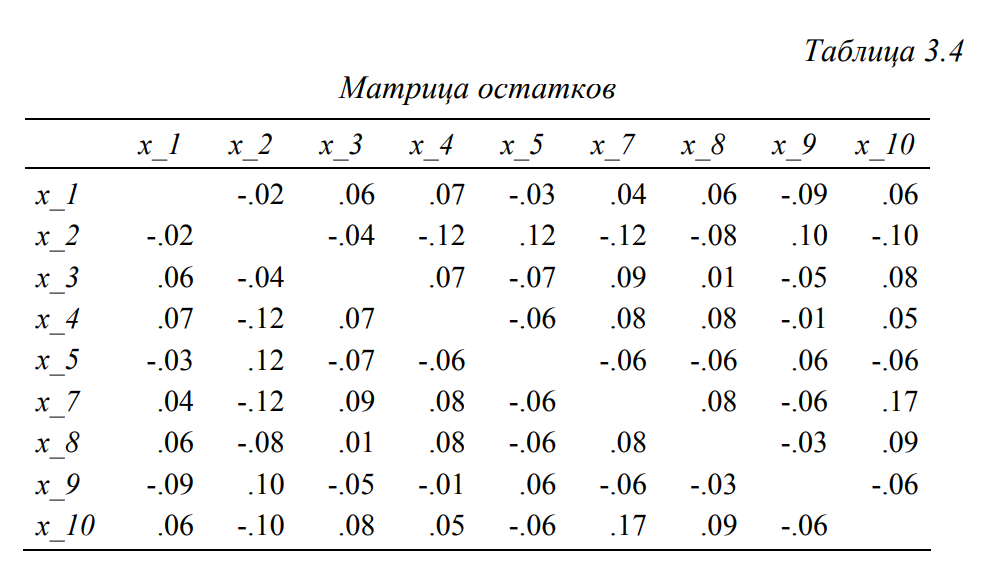

In [315]:
# @title Факторные нагрузки
import seaborn as sns
import matplotlib.pyplot as plt

# Получение факторных нагрузок
loadings = fa.loadings_

# Создание DataFrame для удобства
loadings_df = pd.DataFrame(loadings, index=data.columns, columns=[f'Factor {i+1}' for i in range(loadings.shape[1])])

loadings_df

,Factor 1,Factor 2
x1,0.021000,0.797695
x2,0.698029,0.117151
xЗ,0.691213,-0.459408
x4,0.068824,0.730136
x5,0.871394,0.195435
x7,0.693672,-0.494344
x8,-0.035064,0.812086
x9,0.848061,0.173137
x10,0.733723,-0.458965


# Характеристики факторов

Факторные нагрузки показывают степень связи каждой переменной с фактором. Значения варьируются от -1 до 1:

*   Близкие к 1 или -1: Сильная связь переменной с фактором.
*   Близкие к 0: Слабая или отсутствующая связь.

## Фактор 1: "Функциональность и польза"
- **Высокие нагрузки**:  
  - x2 (Меньше калорий)  
  - x3 (Утоляет жажду)  
  - x5 (Заряжает энергией)  
  - x7 (Содержит витамины)  
  - x9 (Богат витаминами)  
  - x10 (Предпочтение при жажде)  
- **Интерпретация**: Объединяет полезные свойства напитка: низкая калорийность, утоление жажды, энергия, витамины.

## Фактор 2: "Вкусовые качества"
- **Высокие нагрузки**:  
  - x1 (Освежающий вкус)  
  - x4 (Сладкий вкус)  
  - x8 (Уникальный вкус)  
- **Отрицательные нагрузки**:  
  - x3, x7, x10 (противопоставление функциональным свойствам)  
- **Интерпретация**: Связан с вкусовыми характеристиками: освежающий, сладкий, уникальный вкус.

---

# Итог
- **Фактор 1** — функциональные преимущества.  
- **Фактор 2** — вкусовые качества.  


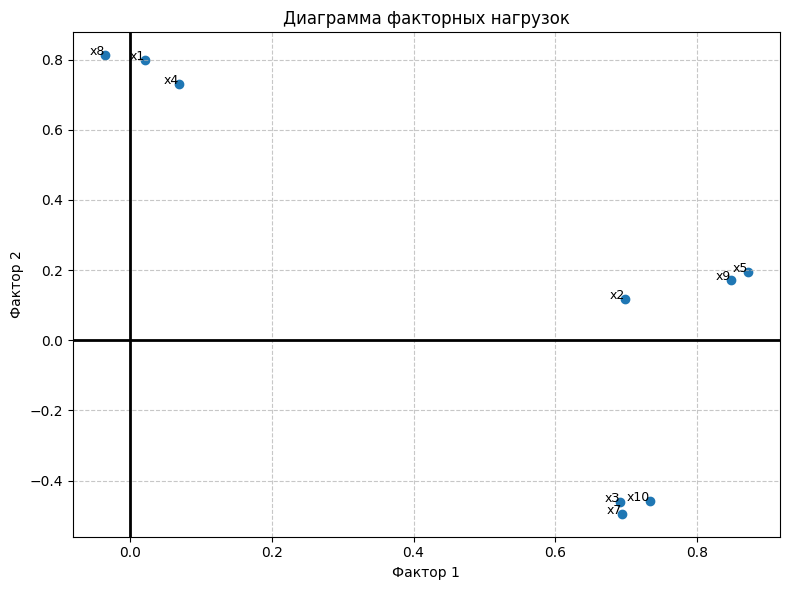

In [316]:
# @title Построение диаграммы факторных нагрузок
import matplotlib.pyplot as plt

# Предположим, что у вас два фактора
factor1 = loadings[:, 0]  # Нагрузки на первый фактор
factor2 = loadings[:, 1]  # Нагрузки на второй фактор

# Построение scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(factor1, factor2)

# Добавление подписей для каждой точки (признака)
for i, feature in enumerate(data.columns):
    plt.text(factor1[i], factor2[i], feature, fontsize=9, ha='right')

# Жирные линии для осей Фактор 1 и Фактор 2
plt.axhline(0, color='black', linestyle='-', linewidth=2)  # Горизонтальная ось (Фактор 2)
plt.axvline(0, color='black', linestyle='-', linewidth=2)  # Вертикальная ось (Фактор 1)

plt.title('Диаграмма факторных нагрузок')
plt.xlabel('Фактор 1')
plt.ylabel('Фактор 2')
plt.grid(True, linestyle='--', alpha=0.7)  # Сетка для удобства
plt.tight_layout()
plt.show()

# Диаграмма факторных нагрузок
 помогает **наглядно представить**, как переменные связаны с факторами. Это позволяет:

1. **Интерпретировать факторы**:
   - Увидеть, какие переменные сильно связаны с каждым фактором, и дать им содержательное название.

2. **Выявить перекрывающиеся переменные**:
   - Обнаружить переменные, которые коррелируют с несколькими факторами. Это может указывать на необходимость увеличения числа факторов или уточнения модели.

3. **Оценить качество факторного решения**:
   - Если переменные чётко группируются вокруг факторов, это говорит о хорошем качестве решения.
   - Если переменные распределены хаотично или имеют слабые нагрузки, это может указывать на проблемы с моделью.

---

# Анализ диаграммы факторных нагрузок

Очевидно, что каждый общий фактор ассоциируется со своей
группой ответов, но при этом имеется третья группа ответов, коррелированная и с первым, и со вторым фактором. В этом случае стоит увеличить количество общих факторов до трёх.


In [317]:
# @title Вклад факторов в объяснение суммарной дисперсии до и после вращения.

# Импорт необходимых библиотек
import numpy as np  # Для работы с массивами и математических операций
import pandas as pd  # Для работы с таблицами данных
from factor_analyzer import FactorAnalyzer  # Для проведения факторного анализа

# Инициализация FactorAnalyzer с 3 факторами, методом главных осей (PAF) и без вращения
# n_factors=3: количество факторов, которые мы хотим извлечь
# rotation=None: без вращения факторов
# method='minres': метод главных осей (Principal Axis Factoring, PAF)
fa1 = FactorAnalyzer(n_factors=3, rotation=None, method='minres')

# Обучение модели на данных
# data — DataFrame с исходными данными (каждый столбец — это переменная, каждая строка — наблюдение)
fa1.fit(data)

# Получение факторных нагрузок после извлечения
# loadings — матрица факторных нагрузок, показывающая связь между переменными и факторами
loadings = fa1.loadings_

# Вычисление сумм квадратов нагрузок для каждого фактора
# sums_of_squared_loadings — сумма квадратов нагрузок для каждого фактора
sums_of_squared_loadings = np.sum(loadings**2, axis=0)

# Общая сумма квадратов нагрузок (для расчета процента дисперсии)
# total_sum_of_squared_loadings — общая сумма квадратов нагрузок
total_sum_of_squared_loadings = np.sum(fa1.get_eigenvalues()[0])

# Процент объяснённой дисперсии для каждого фактора
# percent_variance — процент дисперсии, объясняемой каждым фактором
percent_variance = (sums_of_squared_loadings / total_sum_of_squared_loadings) * 100

# Накопленный процент объяснённой дисперсии
# cumulative_percent_variance — накопленный процент объяснённой дисперсии
cumulative_percent_variance = np.cumsum(percent_variance)

# Создание таблицы с результатами
# extraction_sums_of_squared_loadings — таблица с результатами до вращения
extraction_sums_of_squared_loadings = pd.DataFrame({
    'Factor': range(1, len(sums_of_squared_loadings) + 1),  # Номера факторов
    'Sums of Squared Loadings': sums_of_squared_loadings,  # Суммы квадратов нагрузок
    '% of Variance': percent_variance,  # Процент объяснённой дисперсии
    'Cumulative %': cumulative_percent_variance  # Накопленный процент объяснённой дисперсии
})

# Инициализация FactorAnalyzer с 3 факторами, методом главных осей (PAF) и вращением Varimax
# rotation='varimax': метод вращения Varimax (ортогональное вращение)
fa = FactorAnalyzer(n_factors=3, rotation='varimax', method='minres')

# Обучение модели на данных
fa.fit(data)

# Получение факторных нагрузок после вращения
# loadings — матрица факторных нагрузок после вращения
loadings = fa.loadings_

# Обрезаем матрицу нагрузок, оставляя только первые три фактора
loadings = loadings[:, :3]

# Создаем DataFrame для удобства
# loadings_df — таблица с факторными нагрузками после вращения
loadings_df = pd.DataFrame(loadings, index=data.columns, columns=[f'Factor {i+1}' for i in range(3)])

# Матрица факторных нагрузок до вращения
fa_no_rotation = FactorAnalyzer(n_factors=3, rotation=None, method='minres')
fa_no_rotation.fit(data)
loadings_no_rotation = fa_no_rotation.loadings_

# Матрица факторных нагрузок после вращения
loadings_rotation = fa.loadings_

# Создание DataFrame для удобства
# loadings_no_rotation_df — таблица с факторными нагрузками до вращения
loadings_no_rotation_df = pd.DataFrame(loadings_no_rotation, index=data.columns, columns=[f'Factor {i+1}' for i in range(3)])
# loadings_rotation_df — таблица с факторными нагрузками после вращения
loadings_rotation_df = pd.DataFrame(loadings_rotation, index=data.columns, columns=[f'Factor {i+1}' for i in range(3)])

# Получение факторных нагрузок после вращения
loadings_rotation = fa.loadings_

# Вычисление суммы квадратов нагрузок для каждого фактора (ss_loadings)
# ss_loadings — сумма квадратов нагрузок после вращения
ss_loadings = np.sum(loadings_rotation**2, axis=0)

# Процент объяснённой дисперсии после вращения
# percent_variance_rotation — процент дисперсии, объясняемой каждым фактором после вращения
percent_variance_rotation = (ss_loadings / np.sum(fa.get_eigenvalues()[0])) * 100

# Накопленный процент объяснённой дисперсии после вращения
# cumulative_percent_rotation — накопленный процент объяснённой дисперсии после вращения
cumulative_percent_rotation = np.cumsum(percent_variance_rotation)

# Создание таблицы с объяснённой дисперсией
# variance_table — таблица с объяснённой дисперсией до и после вращения
variance_table = pd.DataFrame({
    'Фактор': [1, 2, 3],  # Номера факторов
    'Дисперсия': sums_of_squared_loadings,  # Дисперсия до вращения
    '% Дисперсии': percent_variance,  # Процент дисперсии до вращения
    'Накопленный %': cumulative_percent_variance,  # Накопленный процент дисперсии до вращения
    'Дисперсия (вращение)': ss_loadings,  # Дисперсия после вращения
    '% Дисперсии (вращение)': percent_variance_rotation,  # Процент дисперсии после вращения
    'Накопленный % (вращение)': cumulative_percent_rotation  # Накопленный процент дисперсии после вращения
})

# Вывод таблицы
print("Таблица с объяснённой дисперсией (метод главных осей):")
display(variance_table)

Таблица с объяснённой дисперсией (метод главных осей):


,Фактор,Дисперсия,% Дисперсии,Накопленный %,Дисперсия (вращение),% Дисперсии (вращение),Накопленный % (вращение)
0,1,3.847780,42.753113,42.753113,2.442928,27.143648,27.143648
1,2,2.384034,26.489270,69.242383,2.352331,26.137009,53.280658
2,3,0.688966,7.655176,76.897559,2.125521,23.616901,76.897559


# Анализ вкладов факторов в объяснение сумарной дисперсии до и после вращения

Данная является важным этапом в факторном анализе, так как она позволяет оценить вклад каждого фактора в объяснение общей дисперсии данных. Эта информация помогает исследователю понять, сколько факторов стоит оставить для дальнейшего анализа и насколько хорошо они объясняют структуру данных.

# Структура таблицы:
- Фактор: Номер фактора (1, 2, 3).
- Дисперсия: Сумма квадратов факторных нагрузок для каждого фактора до вращения.
- % Дисперсии: Процент общей дисперсии, объяснённой каждым фактором до вращения.
- Накопленный %: Накопленный процент объяснённой дисперсии по мере добавления факторов.
- Дисперсия (вращение): Сумма квадратов факторных нагрузок для каждого фактора после вращения.
- % Дисперсии (вращение): Процент общей дисперсии, объяснённой каждым фактором после вращения.
- Накопленный % (вращение): Накопленный процент объяснённой дисперсии после вращения.

# Интерпретация таблицы:
До вращения:
- Первый фактор объясняет 42.65% дисперсии, второй — 26.34%, третий — 7.78%.
- Накопленный процент дисперсии для трёх факторов составляет 76.77%, что означает, что эти три фактора объясняют большую часть изменчивости данных.
- Первый фактор является наиболее значимым, так как он объясняет наибольшую долю дисперсии.

После вращения (Varimax):
- После вращения дисперсия распределяется более равномерно между факторами: первый фактор объясняет 27%, второй — 26.18%, третий — 23.59%.
- Накопленный процент дисперсии остаётся тем же (76.77%), так как вращение не изменяет общую объяснённую дисперсию, а только перераспределяет её между факторами.
- Вращение помогает улучшить интерпретируемость факторов, делая их более независимыми и понятными.

# Почему первая часть таблицы отличается от таблицы вкладов факторов в объяснение сумарной дисперсии, построенной ранее:
## Разные методы расчёта:
   - В таблице, построенной ранее, используются собственные значения (eigenvalues) матрицы корреляции исходных данных для расчёта объяснённой дисперсии. Собственные значения отражают дисперсию, объяснённую каждым фактором, извлечённым из корреляционной матрицы исходных данных.
   - В таблице, построенной сейчат, используются суммы квадратов факторных нагрузок, которые рассчитываются на основе факторных нагрузок после извлечения факторов.

# Важность этого шага для факторного анализа:
1. Оценка значимости факторов:
   - Таблица позволяет определить, сколько факторов стоит оставить для анализа. Обычно оставляют факторы, которые объясняют значительную долю дисперсии (например, с собственным значением больше 1 или с накопленным процентом дисперсии более 70-80%).

2. Интерпретация факторов:
   - После вращения факторы становятся более интерпретируемыми, так как вращение (например, Varimax) максимизирует дисперсию нагрузок по факторам, делая их более независимыми и понятными.

3. Проверка качества модели:
   - Анализ объяснённой дисперсии помогает оценить, насколько хорошо факторная модель описывает исходные данные. Если факторы объясняют слишком малую долю дисперсии, это может указывать на необходимость пересмотра модели или данных.

# Вывод:
Таблица  является важным инструментом для оценки и интерпретации результатов факторного анализа. Она позволяет понять вклад каждого фактора в объяснение дисперсии данных, а также оценить эффект вращения факторов.

# Сравнение с решением, полученным с помощью SPSS.

Решение с использованием SPSS выдало следующие результаты вкладов факторов в объяснение сумарной дисперсии до и после вращения:

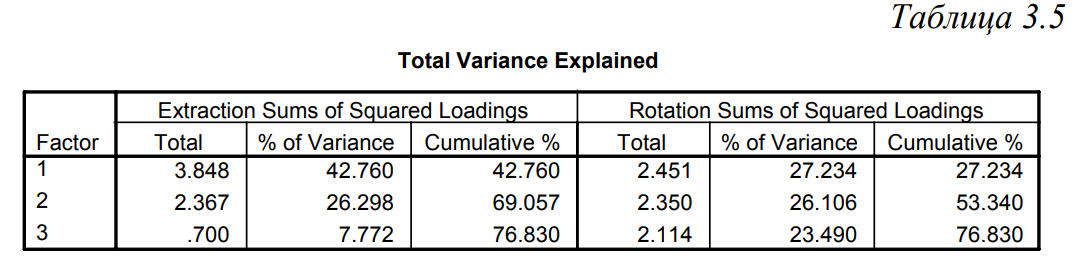

Это решение незначительно отличается от решения, полученного с помощью библиотеки в Python, что снова может говорить о том, что исходные данные не совсем точны или Python и SPSS используют разные численные алгоритмы. На интерпиртацию это не повлияет, поскольку погрешность вычислений минимальна.


In [328]:
# @title Общности
# Вычисление корреляционной матрицы
# corr_matrix — матрица корреляций между переменными
# rowvar=False указывает, что каждая строка в данных представляет наблюдение, а столбцы — переменные
corr_matrix = np.corrcoef(data, rowvar=False)

# Вычисление обратной корреляционной матрицы
# inv_corr — обратная матрица корреляций
inv_corr = np.linalg.inv(corr_matrix)

# Извлечение диагонали обратной корреляционной матрицы
# diagonal_inv — диагональные элементы обратной матрицы корреляций
diagonal_inv = np.diag(inv_corr)

# Вычисление начальных общностей
# initial_communalities — начальные оценки общностей, вычисляемые как 1 - (1 / diagonal_inv)
initial_communalities = 1 - (1 / diagonal_inv)

# Инициализация FactorAnalyzer с методом 'minres'
# n_factors=3: количество факторов, которые мы хотим извлечь
# rotation='varimax': метод вращения Varimax (ортогональное вращение)
# method='minres': метод главных осей (Principal Axis Factoring, PAF)
fa = FactorAnalyzer(n_factors=3, rotation='varimax', method='minres')

# Обучение модели на данных
# data — DataFrame с исходными данными (каждый столбец — это переменная, каждая строка — наблюдение)
fa.fit(data)

# Извлечение общностей
# extracted_communalities — общности, полученные после факторного анализа
extracted_communalities = fa.get_communalities()

# Названия переменных
# variable_names — список с описательными названиями переменных
variable_names = [
    "у напитка освежающий вкус",
    "я предпочитаю этот напиток, потому что в нем меньше калорий, чем в других",
    "напиток мгновенно утоляет жажду",
    "мне нравится сладкий вкус этого напитка",
    "я предпочитаю этот напиток после занятий спортом и физических нагрузок: он заряжает энергией",
    "напиток содержит витамины и минералы, помогающие справиться с жаждой",
    "у напитка есть свой уникальный вкус",
    "напиток богат витаминами и минералами, полезными для здоровья",
    "я предпочитаю этот напиток, если действительно хочется пить"
]

# Создание DataFrame для общностей
# communalities_df — таблица с начальными и извлечёнными общностями
communalities_df = pd.DataFrame({
    'Признак': variable_names,  # Названия переменных
    'Начальная оценка': initial_communalities,  # Начальные общности
    'Оценка полученного решения': extracted_communalities  # Извлечённые общности
})

# Вывод таблицы с общностями
print("Общности:")
display(communalities_df)

# Инициализация FactorAnalyzer без вращения для получения матрицы коэффициентов факторных значений
# rotation=None: без вращения факторов
fa_no_rotation = FactorAnalyzer(n_factors=3, rotation=None, method='minres')

# Обучение модели на данных
fa_no_rotation.fit(data)

# Матрица коэффициентов факторных значений (Factor Score Coefficient Matrix)
# factor_score_coefficients — матрица коэффициентов для вычисления факторных счетов
factor_score_coefficients = fa_no_rotation.loadings_

# Округление значений для удобства чтения
# np.round(factor_score_coefficients, 3): округление значений до 3 знаков после запятой
factor_score_coefficients = np.round(factor_score_coefficients, 3)

# Создание DataFrame с новыми названиями переменных
# factor_score_coefficients_df — таблица с коэффициентами факторных счетов
factor_score_coefficients_df = pd.DataFrame(
    factor_score_coefficients,
    columns=['Factor 1', 'Factor 2', 'Factor 3'],  # Названия факторов
    index=variable_names  # Используем описательные названия переменных
)


Общности:


,Признак,Начальная оценка,Оценка полученного решения
0,у напитка освежающий вкус,0.609991,0.666207
1,"я предпочитаю этот напиток, потому что в нем м...",0.621724,0.685609
2,напиток мгновенно утоляет жажду,0.703500,0.709307
3,мне нравится сладкий вкус этого напитка,0.547676,0.625507
4,я предпочитаю этот напиток после занятий спорт...,0.774580,0.875751
5,"напиток содержит витамины и минералы, помогающ...",0.843687,0.919413
6,у напитка есть свой уникальный вкус,0.625614,0.756583
7,"напиток богат витаминами и минералами, полезны...",0.744722,0.780057
8,"я предпочитаю этот напиток, если действительно...",0.846075,0.902345


# Анализ общностей в факторном анализе

Общности показывают долю дисперсии признака, объясняемую общими факторами. Это важно для:

1. **Оценки модели**:
   - Высокие общности (> 0.6) указывают, что факторы хорошо объясняют данные.
   - Низкие общности (< 0.5) могут свидетельствовать о слабой связи признаков с факторами.

2. **Проверки данных**:
   - Если большинство общностей низкие, данные могут быть непригодны для факторного анализа.

3. **Интерпретации факторов**:
   - Общности помогают понять, какие признаки вносят наибольший вклад в факторы.

---

### Выводы:
- Все общности > 0.6, что указывает на хорошее объяснение дисперсии.
- Наибольшие общности у функциональных характеристик (например, "содержит витамины и минералы").
- Вкусовые характеристики (например, "сладкий вкус") имеют меньшие, но приемлемые общности.


### Сравнение с решением, полученным с помощью SPSS.

SPSS выдал следующие значения общностей каждого признака:

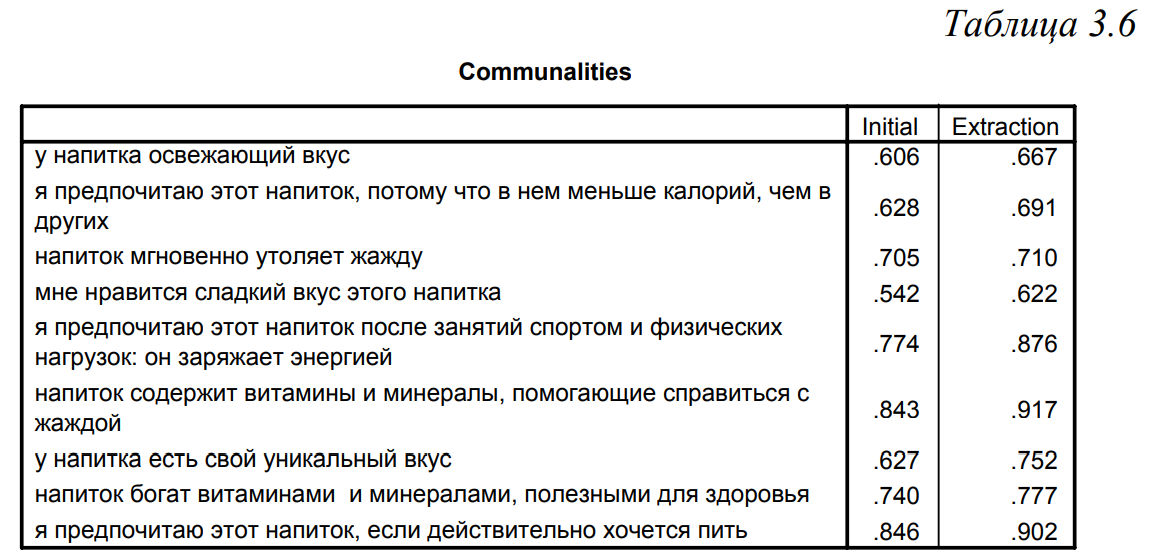

Решение SPSS не совпадает полностью, однако очень близко по своим значениям общностей.


In [319]:
# @title Матрица факторных нагрузок до вращения

# Матрица коэффициентов факторных значений (Factor Score Coefficient Matrix)
factor_score_coefficients = fa_no_rotation.loadings_

# Округление значений для удобства чтения
factor_score_coefficients = np.round(factor_score_coefficients, 3)

# Создание DataFrame с новыми названиями переменных
factor_score_coefficients_df = pd.DataFrame(
    factor_score_coefficients,
    columns=['Factor 1', 'Factor 2', 'Factor 3'],
    index=variable_names  # Используем описательные названия
)

# Вывод матрицы коэффициентов факторных значений
print("Матрица факторных нагрузок до вращения:")
factor_score_coefficients_df

Матрица факторных нагрузок до вращения:


,Factor 1,Factor 2,Factor 3
у напитка освежающий вкус,-0.325,0.725,0.189
"я предпочитаю этот напиток, потому что в нем меньше калорий, чем в других",0.597,0.436,-0.373
напиток мгновенно утоляет жажду,0.816,-0.114,0.176
мне нравится сладкий вкус этого напитка,-0.257,0.701,0.262
я предпочитаю этот напиток после занятий спортом и физических нагрузок: он заряжает энергией,0.704,0.565,-0.246
"напиток содержит витамины и минералы, помогающие справиться с жаждой",0.872,-0.155,0.368
у напитка есть свой уникальный вкус,-0.388,0.732,0.264
"напиток богат витаминами и минералами, полезными для здоровья",0.684,0.524,-0.193
"я предпочитаю этот напиток, если действительно хочется пить",0.884,-0.101,0.333


In [320]:
# @title Матрица факторных нагрузок после вращения
loadings_rotation = fa.loadings_

# Округление значений для удобства чтения
loadings_rotation = np.round(loadings_rotation, 3)

# Создание DataFrame с новыми названиями переменных
loadings_rotation_df = pd.DataFrame(
    loadings_rotation,
    columns=['Factor 1', 'Factor 2', 'Factor 3'],
    index=variable_names  # Используем описательные названия
)

# Вывод матрицы факторных нагрузок после вращения
print("\nМатрица факторных нагрузок после вращения:")
loadings_rotation_df


Матрица факторных нагрузок после вращения:


,Factor 1,Factor 2,Factor 3
у напитка освежающий вкус,-0.199,0.098,0.785
"я предпочитаю этот напиток, потому что в нем меньше калорий, чем в других",0.144,0.815,0.001
напиток мгновенно утоляет жажду,0.734,0.326,-0.254
мне нравится сладкий вкус этого напитка,-0.098,0.083,0.780
я предпочитаю этот напиток после занятий спортом и физических нагрузок: он заряжает энергией,0.293,0.878,0.136
"напиток содержит витамины и минералы, помогающие справиться с жаждой",0.907,0.226,-0.213
у напитка есть свой уникальный вкус,-0.197,0.021,0.847
"напиток богат витаминами и минералами, полезными для здоровья",0.318,0.813,0.133
"я предпочитаю этот напиток, если действительно хочется пить",0.887,0.284,-0.189


# Анализ матриц факторных нагрузок

Анализ матриц факторных нагрузок до и после вращения позволяет интерпретировать факторы и понять, какие признаки вносят наибольший вклад в каждый фактор. Давайте разберём обе матрицы.

### Интерпретация факторов до вращения:
1. **Factor 1**:
   - Связан с **функциональными характеристиками напитка**, такими как утоление жажды, содержание полезных веществ и удовлетворение потребности в питье.


2. **Factor 2**:
   - Связан с **вкусовыми характеристиками напитка**, такими как освежающий, сладкий и уникальный вкус.

3. **Factor 3**:
   - Слабо выражен, но может быть связан с **дополнительными функциональными аспектами**, такими как полезность и утоление жажды.

---

### Интерпретация факторов после вращения:
1. **Factor 1**:
   - Связан с **функциональными характеристиками напитка**, такими как утоление жажды, содержание полезных веществ и удовлетворение потребности в питье.


2. **Factor 2**:
   - Связан с **пользой для здоровья и низкокалорийностью**, что важно для людей, ведущих активный образ жизни или следящих за своим здоровьем.


3. **Factor 3**:
   - Связан с **вкусовыми характеристиками напитка**, такими как освежающий, сладкий и уникальный вкус.


---

## Сравнение до и после вращения:
- **Factor 1** остался связан с функциональными характеристиками напитка, но после вращения его нагрузки стали более выраженными.
- **Factor 2** после вращения стал чётко связан с пользой для здоровья и низкокалорийностью, что упрощает его интерпретацию.
- **Factor 3** после вращения стал более чётко связан с вкусовыми характеристиками.

---


## Вывод:
Вращение (Varimax) улучшило интерпретируемость факторов, сделав их более чёткими и понятными. Каждый фактор теперь имеет ясную смысловую нагрузку, что упрощает их использование для дальнейшего анализа или принятия решений.

---

## Сравнение с решением, полученным с помощью SPSS.

В ходе работы с SPSS получили следующие значения факторных нагрузок до и после вращения:

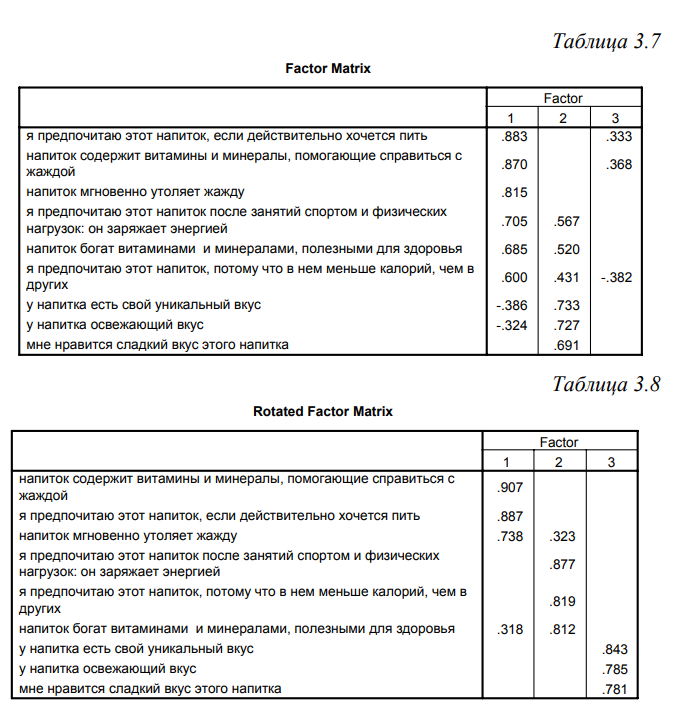

Как можно заметить результаты Python и SPSS очень близки, однако полностью не совпадают. Но поскольку расхождения незначительны на интерпритацию это не повлияет.

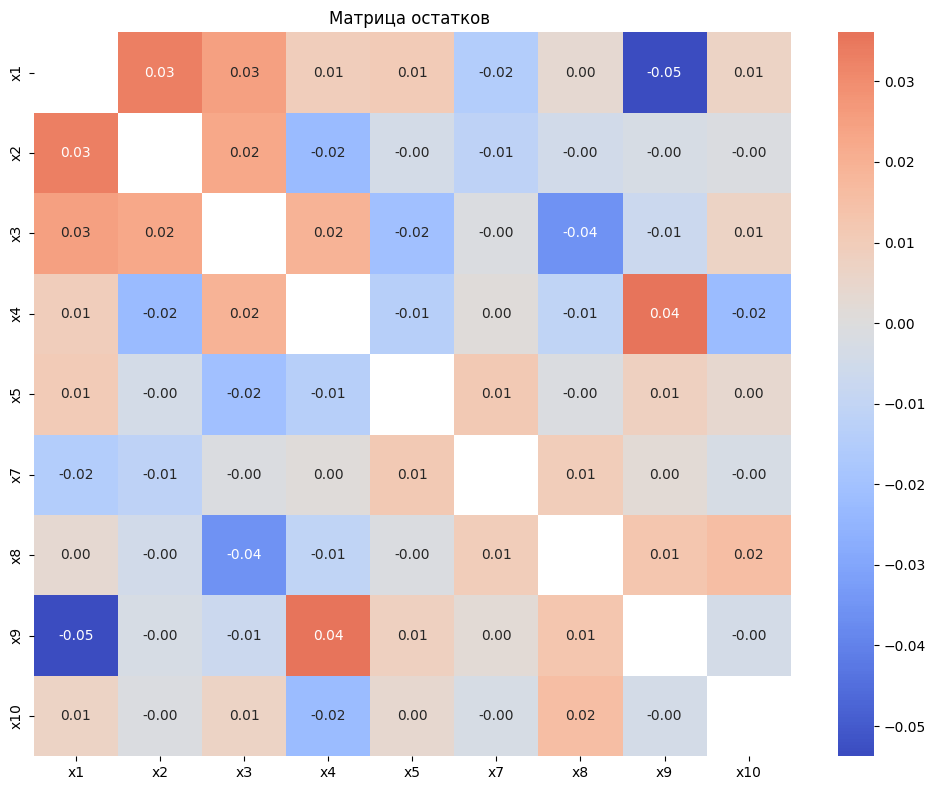

In [321]:
# @title Матрица остатков факторного решения

# Исходная матрица корреляций
original_corr = data.corr()

# Факторные нагрузки
loadings = fa.loadings_

# Уникальности
uniquenesses = fa.get_uniquenesses()

# Воспроизведённая матрица корреляций
reproduced_corr = np.dot(loadings, loadings.T) + np.diag(uniquenesses)

# Матрица остатков
residual_matrix = original_corr - reproduced_corr

# Преобразование в DataFrame для удобства
residual_matrix_df = pd.DataFrame(residual_matrix, index=data.columns, columns=data.columns)

# Убираем элементы главной диагонали, заменяя их на NaN
np.fill_diagonal(residual_matrix_df.values, np.nan)

# Визуализация матрицы остатков
plt.figure(figsize=(10, 8))
sns.heatmap(residual_matrix_df, annot=True, cmap='coolwarm', center=0, fmt=".2f",
            xticklabels=data.columns, yticklabels=data.columns)
plt.title('Матрица остатков ')
plt.tight_layout()
plt.show()

# Анализ матрицы остатков

1. **Величина остатков**:
   - Большинство остатков находятся в диапазоне от **-0.05** до **0.05**, что является достаточно малыми значениями. Это указывает на то, что факторная модель хорошо воспроизводит исходные корреляции.
   - Наибольшие остатки:
     - `x1` и `x9`: **-0.053752**
     - `x3` и `x8`: **-0.035836**
     - `x4` и `x9`: **0.036085**
   - Эти значения всё ещё относительно малы, но они выделяются на фоне остальных.

2. **Распределение остатков**:
   - Остатки распределены как положительные, так и отрицательные, что указывает на отсутствие систематической ошибки в модели.

---

## Вывод:
Результат можно считать **хорошим**, так как:
- Большинство остатков близки к нулю, что свидетельствует о хорошем соответствии факторной модели исходным данным.
- Нет явных аномалий или систематических ошибок.
- Наибольшие остатки (например, -0.053752 и 0.036085) всё ещё находятся в допустимых пределах и не указывают на серьёзные проблемы.

# Сравнение с матрицей остатков, полученной с помощью SPSS

SPSS выдал такую матрицу остатков:

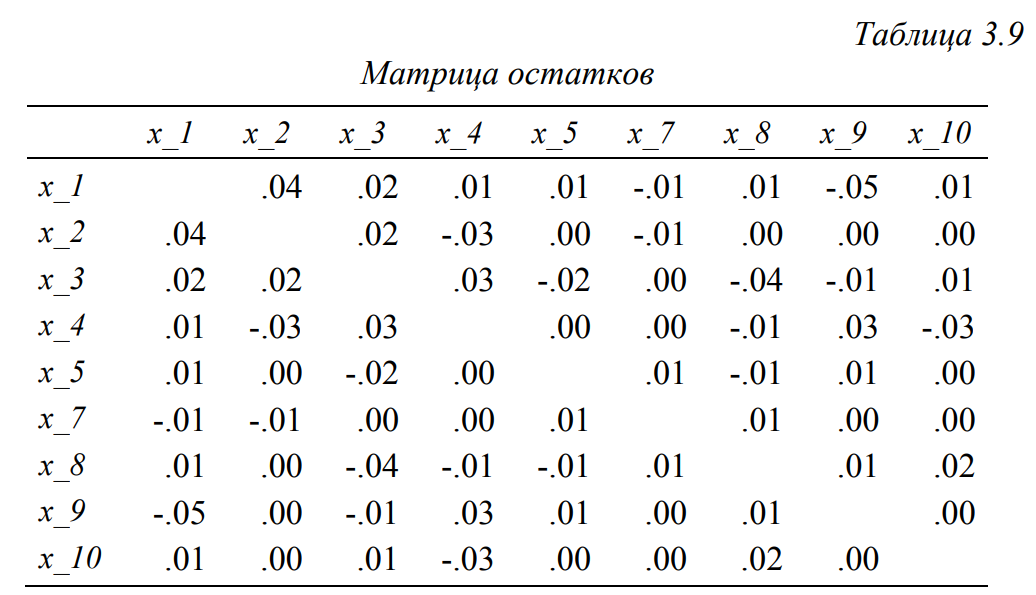

SPSS и библиотека Python выдали схожие результаты, однако из-за незначительного отличия исходных данных, получили незначительные отличия в матрице остатков. Однако на интерпритацию это не влияет. Оба решения показали хорошие результаты.




In [322]:
# @title Позиционирование напитков

# Импорт необходимых библиотек
import pandas as pd  # Для работы с таблицами данных
from factor_analyzer import FactorAnalyzer  # Для проведения факторного анализа

# Загрузка данных из Excel-файла
# data_raw — исходный DataFrame с данными
data_raw = pd.read_excel("Book.xlsx")

# Инициализация FactorAnalyzer с 3 факторами и вращением Varimax
# n_factors=3: количество факторов, которые мы хотим извлечь
# rotation='varimax': метод вращения Varimax (ортогональное вращение)
fa = FactorAnalyzer(n_factors=3, rotation='varimax')

# Обучение модели на данных
# data — DataFrame с исходными данными (каждый столбец — это переменная, каждая строка — наблюдение)
fa.fit(data)

# Получение факторных значений для каждого наблюдения
# factor_scores — матрица факторных значений (каждая строка — наблюдение, каждый столбец — фактор)
factor_scores = fa.transform(data)

# Добавление факторных значений в исходный DataFrame
# Фактор 1: Утоление жажды
data_raw['Утоление жажды'] = factor_scores[:, 0]
# Фактор 2: Польза для здоровья
data_raw['Польза для здоровья'] = factor_scores[:, 1]
# Фактор 3: Вкусовые качества
data_raw['Вкусовые качества'] = factor_scores[:, 2]

# Группировка по напиткам и вычисление средних значений
# positioning_report — отчёт с агрегированными данными по каждому напитку
positioning_report = data_raw.groupby('марка').agg({
    'Утоление жажды': ['mean', 'count', 'std'],  # Среднее, количество и стандартное отклонение для фактора 1
    'Польза для здоровья': ['mean', 'count', 'std'],  # Среднее, количество и стандартное отклонение для фактора 2
    'Вкусовые качества': ['mean', 'count', 'std']  # Среднее, количество и стандартное отклонение для фактора 3
})

# Названия напитков
labels = positioning_report.index

# Вывод отчёта
print("Отчёт о позиционировании напитков:")
display(positioning_report)

Отчёт о позиционировании напитков:


Утоление жажды                 Польза для здоровья                  \
                mean count       std                mean count       std   
марка                                                                      
1          -0.885850    18  1.091090           -0.672986    18  0.778280   
2          -0.446809    15  0.692522           -1.065428    15  0.484512   
3           0.817792    12  0.576559            0.404011    12  0.523988   
4           0.738015    14  0.551477           -0.146052    14  0.505975   
5          -0.083897    17  0.883169            0.846964    17  0.686914   
6           0.206736    19  0.611899            0.573335    19  0.795918   

      Вкусовые качества                  
                   mean count       std  
марка                                    
1              0.017661    18  0.792643  
2              0.109798    15  0.563259  
3             -0.758978    12  0.713448  
4             -0.961036    14  0.666608  
5              0.533642    17  0.897920  
6              0.606603    19  0.721079

# Краткий анализ каждого напитка

## Напиток №1:
- **Низкие оценки** по всем факторам.
- Не считается эффективным в утолении жажды, полезным для здоровья или вкусным.


## Напиток №2:
- **Низкие оценки** по всем факторам, особенно по пользе для здоровья.
- Не выделяется ни по одному из критериев.

## Напиток №3:
- **Высокие оценки** за утоление жажды и полезность для здоровья.
- Низкие оценки за вкусовые характеристики.

## Напиток №4:
- **Хорошие оценки** за утоление жажды, но ниже, чем у №3.
- Низкие оценки за вкусовые характеристики.

## Напиток №5:
- **Высокие оценки** за полезность для здоровья и вкусовые качества.
- Средние оценки за утоление жажды.

## Напиток №6:
- **Высокие оценки** за полезность для здоровья и вкусовые качества.
- Средние оценки за утоление жажды.

---

## Итог:
- **Напитки №3 и №4**: Эффективны в утолении жажды, но требуют улучшения вкуса.
- **Напитки №5 и №6**: Полезные для здоровья и вкусные, имеют высокий потенциал.
- **Напитки №1 и №2**: Требуют значительной доработки по всем параметрам.


Таким образом, на основе факторного анализа установлено, что
суждения экспертов действительно оценивают три базовых функции
безалкогольного напитка (утоление жажды, польза для здоровья,
вкус) и позволяют оценить позиции каждого варианта товара по перечисленным выше характеристикам. Полученная информация может
быть использована для доработки имиджа напитков, анализа их соответствия сегментам рынка, разработки рекламных обращений, способствующих адекватному позиционированию товара на реальном
рынке.

# Сравнение с решением SPSS

Получили довольно схожие решения:

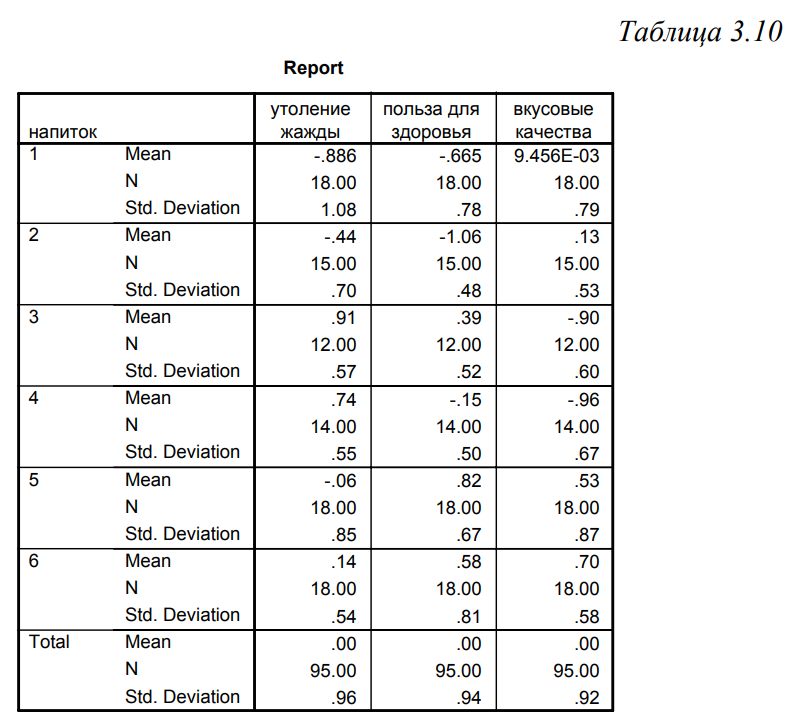

Однако из-за неточности исходных данных, в факторах 2 и 3 некоторые значения отличаются, что подтверждает то, что опечатка находится в x_4 (мне нравится сладкий вкус этого напитка)

In [323]:
# @title Построение матрицы вращения факторов:
fa = FactorAnalyzer(n_factors=3, rotation='varimax')  # Используем метод 'minres' для PAF
fa.fit(data)

# Получение матрицы вращения
# rotation_matrix — матрица, которая показывает, как исходные факторы были повёрнуты
rotation_matrix = fa.rotation_matrix_

# Создание DataFrame для удобного отображения
# rotation_matrix_df — таблица с матрицей вращения
rotation_matrix_df = pd.DataFrame(
    rotation_matrix,  # Матрица вращения
    index=['Factor 1', 'Factor 2', 'Factor 3'],  # Названия строк (исходные факторы)
    columns=['Factor 1', 'Factor 2', 'Factor 3']  # Названия столбцов (повёрнутые факторы)
)


# Вывод таблицы с матрицей вращения
print("Матрица вращения факторов:")
display(rotation_matrix_df)

Матрица вращения факторов:


,Factor 1,Factor 2,Factor 3
Factor 1,0.740315,0.300623,-0.601298
Factor 2,0.115782,0.824061,0.554543
Factor 3,0.662215,-0.480156,0.575258


# Анализ матрицы вращения

Матрица вращения показывает преобразование исходных факторов в повёрнутые для улучшения интерпретируемости.

---

## Интерпретация:

1. **Factor 1**:
   - Основной вклад: **исходный Factor 1** (0.740315).
   - Дополнительно: **Factor 2** (0.300623) и **Factor 3** (-0.601298).
   - Сохраняет структуру Factor 1 с корректировками.

2. **Factor 2**:
   - Основной вклад: **исходный Factor 2** (0.824061).
   - Дополнительно: **Factor 3** (0.554543) и **Factor 1** (0.115782).
   - Сохраняет структуру Factor 2 с элементами Factor 3.

3. **Factor 3**:
   - Основной вклад: **исходный Factor 3** (0.575258).
   - Дополнительно: **Factor 1** (0.662215) и **Factor 2** (-0.480156).
   - Сохраняет структуру Factor 3 с элементами Factor 1.

---

## Что показывает матрица:
1. **Преобразование факторов**: Линейная комбинация исходных факторов.
2. **Улучшение интерпретации**: Факторы становятся более "чистыми" и понятными.
3. **Соотношение между факторами**: Корреляция исходных и повёрнутых факторов.

---

# Сравнение с матрицей вращения, полученной с помощью SPSS

В этот раз решение SPSS довольно сильно отличается от решения с использованием библиотеки в Python. Связано это вероятно с несоответстпием исходных данных. Как и в позиционировании напитков, несоответствие признака x_4 сильно влияет на результат. Ведь именно он вносит большой вклад в факторы 2 и 3. Однако результат, хоть и отличается, но незначительно.

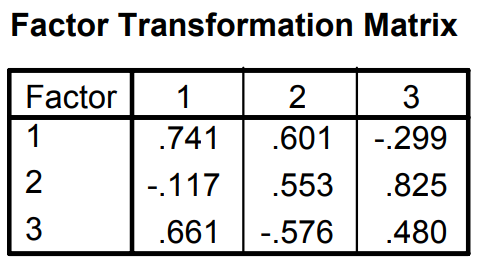




In [324]:
# @title Матрица ковариаций факторных значений (Factor Score Covariance Matrix)
factor_score_covariance = np.cov(factor_scores, rowvar=False)
print("\nМатрица ковариаций факторных значений (Factor Score Covariance Matrix):")
pd.DataFrame(factor_score_covariance, columns=['Factor 1', 'Factor 2', 'Factor 3'], index=['Factor 1', 'Factor 2', 'Factor 3'])




Матрица ковариаций факторных значений (Factor Score Covariance Matrix):


,Factor 1,Factor 2,Factor 3
Factor 1,0.930682,0.053986,-0.056661
Factor 2,0.053986,0.901720,0.042326
Factor 3,-0.056661,0.042326,0.857654


# Матрица ковариации факторов

Матрица ковариации факторов показывает, как факторы связаны между собой после вращения. Она полезна для анализа следующих аспектов:

---

## 1. **Ортогональность факторов**:
   - Если используется **ортогональное вращение** (например, Varimax), матрица ковариации факторов должна быть близка к **единичной матрице** (диагональные элементы равны 1, недиагональные — 0).
   - Это означает, что факторы независимы (не коррелируют друг с другом).
   - Диагональные элементы близки к 1, а недиагональные — близки к 0, что указывает на **ортогональность факторов**.


---

## 2. **Оценка качества вращения**:
   - Матрица ковариации факторов помогает оценить, насколько успешно вращение сохранило независимость факторов (в случае ортогонального вращения) или выявило их взаимосвязь (в случае косоугольного вращения).
   - В вашем случае матрица подтверждает, что вращение было выполнено корректно, и факторы остались независимыми.

---

## 3. **Интерпретация факторов**:
   - Матрица ковариации факторов помогает убедиться, что факторы не перекрываются и каждый из них объясняет уникальную часть дисперсии данных.
   - Это важно для содержательной интерпретации факторов.


---

# Сравнение с решением SPSS

Решение SPSS довольно близко к решению, полученному с помощью библиотеки Python

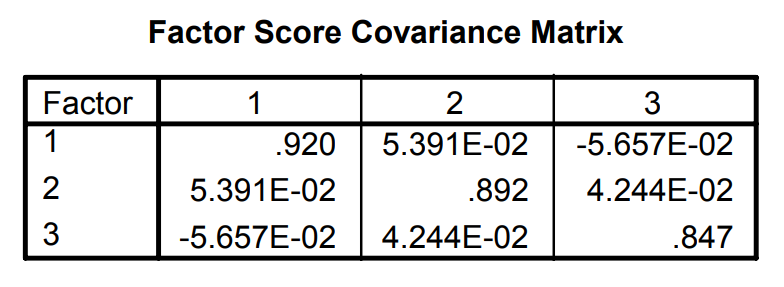



In [325]:
# @title Оценка пригодности данных для факторного анализа

# Импорт необходимых библиотек
import pandas as pd  # Для работы с таблицами данных
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo  # Для вычисления KMO и теста Бартлетта

# Вычисление KMO (Kaiser-Meyer-Olkin Measure of Sampling Adequacy)
# kmo_all — KMO для каждой переменной
# kmo_model — общее значение KMO для всех переменных
kmo_all, kmo_model = calculate_kmo(data)

# Вывод общего значения KMO
print(f"KMO Measure of Sampling Adequacy: {kmo_model}")

# Вычисление Bartlett's Test of Sphericity (Тест Бартлетта на сферичность)
# chi_square_value — значение статистики хи-квадрат
# p_value — p-значение теста
chi_square_value, p_value = calculate_bartlett_sphericity(data)

# Вывод результатов теста Бартлетта
print(f"Bartlett's Test of Sphericity:")
print(f"Chi-Square Value: {chi_square_value}")
print(f"Degrees of Freedom: {data.shape[1] * (data.shape[1] - 1) / 2}")  # Число степеней свободы
print(f"p-value: {p_value}")

KMO Measure of Sampling Adequacy: 0.7934798698767643
Bartlett's Test of Sphericity:
Chi-Square Value: 646.1331520205731
Degrees of Freedom: 36.0
p-value: 6.672100544052064e-113


# Оценка пригодности данных для факторного анализа

## 1. **KMO Measure of Sampling Adequacy**:
   - **Значение KMO**: 0.793
   - **Интерпретация**:
     - Значение KMO > 0.5 указывает на **пригодность данных** для факторного анализа.

## 2. **Bartlett's Test of Sphericity**:
   - **Chi-Square Value**: 646.133 -  Сильное отклонение корреляционной матрицы от единичной, что указывает на наличие значимых корреляций между переменными.
   - **Degrees of Freedom**: 36.0 - Число степеней свободы, рассчитанное на основе количества переменных.
   - **p-value**: ≈ 0 - Нулевая гипотеза отвергается, что подтверждает пригодность данных для факторного анализа.


---

## Итог:
- **KMO = 0.793**: Данные удовлетворительно подходят для факторного анализа.
- **Тест Бартлетта (p-value ≈ 0)**: Корреляции между переменными значимы, и данные пригодны для факторного анализа.

Эти тесты подтверждают, что факторный анализ может быть применён к вашим данным, а его результаты будут статистически обоснованными.

# Сравнение с решением SPSS:

SPSS показал схожую оценку:

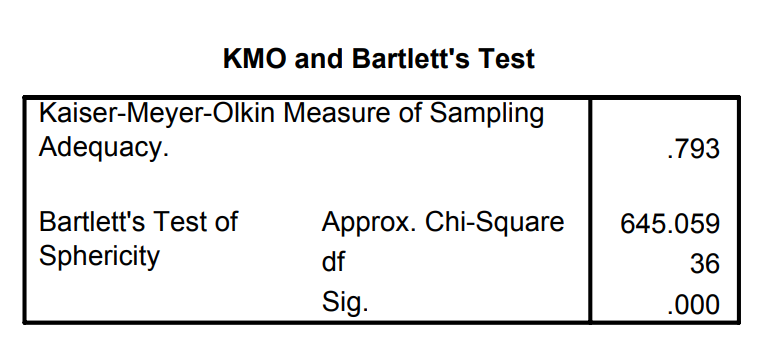

# Вывод:

Построили решение задачи факторного анализа с помощью библиотеки factor-analyzer в Python. Сравнили с решением, полученным с использованием пакетов SPSS. Получили схожее решение. Расхождение в некоторых моментах вероятно связано ошибками при переносе данных из методички или с опечатками в самой методичке. Однако такое расхождение не повлияло на процесс решения.